# Arbitrage scanner
Our goal is to find arbitrage opportunities between 2 Uniswap-like DEXes 
([Uniswap](https://v2.info.uniswap.org/home) and [Sushiswap](https://www.sushi.com/)) for newly mined blocks:

```bash
# Usage example
# Find all arbitrage opportunities in stream mode
#Find existing pairs of tokens
python3 generate_pairs.py
#Find the arbitrage opportunities
python3 ascanner_stream.py
```

## Arbitrage Condition
Let us consider the pair of 2 tokens $(x, y)$. 
Arbitrage opportunity exists if one swaps $\delta x$ for $\delta y$ on the first DEX with further swapping of $\delta y$ 
for $\delta x' > \delta x$ on the another DEX. Thus, we need to solve the following optimization problem
$$
    \delta x ' (\delta x) - \delta x \longrightarrow \max_{\delta x},
$$
Note that the equation $ \delta x ' (\delta x) - \delta x $ is simply the representation for the profit in $x$ token after 
the execution of arbitrage opportunity. In other words, we are simply solving quite natural problem
$$
    \operatorname{profit} \longrightarrow \max
$$
Note that if the maximized profit is less than 0 then the arbitrage opportunity doesn't exist.

Let us suppose that we observe reserves of 2 identical $(x, y)$ pairs on the 2 DEXes of Uniswapv2 type:
$$
    (x_1, y_1), \quad (x_2, y_2)
$$
In the equations above $(x_1, y_1)$ are token reserves of $(x,y)$-pair on the first DEX and $(x_2, y_2)$ are the reserves 
of $(x,y)$-pair on the second DEX. Without loss of generality let us suppose that we firstly swap $\delta x$ for $\delta y$ on the first DEX
with further swapping of $\delta y$ for $\delta x '$ on second DEX. Thus, the functional representation for $\delta x'(\delta x) - \delta x$ 
can be derived from the following equations:
$$
    x_1 y_1 = (x_1 + r_1\delta x) (y_1 - \delta y), \qquad
    x_2 y_2 = (x_1 - \delta x ') (y_2 + r_2\delta y),
$$
It is justed needed to derive $\delta y = ...$ from the left equation and substitute into the right one. 
Note that $r_i = 1 - \phi_i$, where $\phi_i$ are the DEXes' fees. For instance, Sushiswap and Uniswap fees are the same and equal $0.3\%$. 

**In the code fees are calculated in the so called BASIS POINTS (BPS). 1 BPS equals to 0.01\% = 0.0001. Thus, 0.3\% = 30 BPS and 1 - 0.3\% = 9970 BPS.**

After deriving the functional representation for $\delta x'(\delta x) - \delta x$ we are ready to solve the maximization problem
$$
    \delta x ' (\delta x) - \delta x \longrightarrow \max_{\delta x},
$$
by writing first order condition (first order derivative equals zero).

After solving the maximization problem one can derive the arbitrage condition from the following inequality
$$
\delta x ' (\delta x_{\max}) - \delta x_{\max} > 0,
$$ 
where 
$$
    \delta x_{\max} = \arg \max_{\delta x} \left[\delta x ' (\delta x) - \delta x\right].
$$
Thus, the optimal profit can be calculated via 
$$
    \operatorname{profit}_{\max} = \delta x ' (\delta x_{\max}) - \delta x_{\max} 
$$
Strictly speaking, there is also the gas cost that one need to encounter. However, at the moment it is recommended not to think about it. 
There is plenty of work to do already.


## Looking for pairs
It's time to specify the pairs that we are going to use for arbitrage opportunities. It is reasonable to look through all the pairs that 
UniswapV2 and SuhiswapV2 have and then construct pivot table of all the common pairs of 2 DEXes.

For simplicity we will consider the arbitrage opportunities where $x$ token is WETH and $y$ is another token (USDT, USDC, SHIBA, etc.). 
Thus, we will calculate our profit in WETH.

The motivation of using batch requests is the optimized consunming of 
GetBlock requests. Moreover, it is simply much faster.

In [1]:
from utils.providers import get_provider_from_uri
from utils import hex_to_dec
from utils.requests import (
    get_request_all_pairs,
    get_request_balanceof,
    get_request_token0,
    get_request_token1,
    get_request_get_reserves,
)
import json
from const import ADDRESSES, UNISWAPV2_FACTORY_ABI, ERC20_ABI, UNISWAPV2_PAIR_ABI
import pandas as pd
from web3 import Web3

# Let us create py-web3 objects for Ethereum node DDOS
PROVIDER_URI = "https://eth.getblock.io/ee60e639-1307-4c20-8d64-f4441ea4b678/mainnet/"
BATCH_W3 = get_provider_from_uri(PROVIDER_URI, batch=True)
W3 = Web3(BATCH_W3)

In [2]:
# Now let us extract pair addresses for the first 100 pairs via 1 batch request
UNISWAPV2_FACTORY_CONTRACT = W3.eth.contract(
    address=ADDRESSES.uniswapv2_factory, abi=UNISWAPV2_FACTORY_ABI
)
n_pairs = UNISWAPV2_FACTORY_CONTRACT.functions.allPairsLength().call()
print("TOTAL NUMBER OF PAIRS", n_pairs)

tokens0 = []
tokens1 = []
pair_addresses = []
balances = []
block_number = W3.eth.block_number
x = 23500
factory_address = ADDRESSES.uniswapv2_factory
for i in range(0, n_pairs//x + 1):
    pair_ids = range(i*x, min(x*(i+1), n_pairs))
    batch_request = json.dumps(
        [
            get_request_all_pairs(
                factory_address, pair_id, block_number, request_id=pair_id
            )
            for pair_id in pair_ids
        ]

    )

    batch_response = BATCH_W3.make_batch_request(batch_request)

    pair_address = [
        "0x" + response_item["result"][-40:]
        for response_item in batch_response
    ]

    # Extracting token0, token1

    token0_request = json.dumps(
        [
            get_request_token0(pair_address, block_number, request_id=i)
            for i, pair_address in enumerate(pair_address)
        ]
    )

    batch_response = BATCH_W3.make_batch_request(token0_request)
    tokens0 += [
        "0x" + response_item["result"][-40:]
        for response_item in batch_response
    ]

    token1_request = json.dumps(
        [
            get_request_token1(pair_address, block_number, request_id=i)
            for i, pair_address in enumerate(pair_address)
        ]
    )
    batch_response = BATCH_W3.make_batch_request(token1_request)
    tokens1 += [
        "0x" + response_item["result"][-40:]
        for response_item in batch_response
    ]

    # Well, let us calculate how many WETH tokens are located in each pair

    liquidity_request = json.dumps(
        [
            get_request_balanceof(ADDRESSES.weth, pair_address, block_number, request_id=i)
            for i, pair_address in enumerate(pair_address)
        ]
    )
    batch_response = BATCH_W3.make_batch_request(liquidity_request)
    balances += [
        hex_to_dec(response_item["result"])
        for response_item in batch_response
    ]

    pair_addresses += pair_address

uniswap = pd.DataFrame(
{
    "pair_address": pair_addresses,
    "token0": tokens0,
    "token1": tokens1,
    "WETH_balance": balances,
}
)

TOTAL NUMBER OF PAIRS 153127


In [3]:
# Now let us extract pair addresses for the first 100 pairs via 1 batch request
UNISWAPV2_FACTORY_CONTRACT = W3.eth.contract(
    address=ADDRESSES.sushiswapv2_factory, abi=UNISWAPV2_FACTORY_ABI
)
n_pairs = UNISWAPV2_FACTORY_CONTRACT.functions.allPairsLength().call()
print("TOTAL NUMBER OF PAIRS", n_pairs)

tokens0 = []
tokens1 = []
pair_addresses = []
balances = []
block_number = W3.eth.block_number
x = 23500
factory_address = ADDRESSES.sushiswapv2_factory
for i in range(0, n_pairs//x + 1):
    pair_ids = range(i*x, min(x*(i+1), n_pairs))
    batch_request = json.dumps(
        [
            get_request_all_pairs(
                factory_address, pair_id, block_number, request_id=pair_id
            )
            for pair_id in pair_ids
        ]

    )

    batch_response = BATCH_W3.make_batch_request(batch_request)

    pair_address = [
        "0x" + response_item["result"][-40:]
        for response_item in batch_response
    ]

    # Extracting token0, token1

    token0_request = json.dumps(
        [
            get_request_token0(pair_address, block_number, request_id=i)
            for i, pair_address in enumerate(pair_address)
        ]
    )

    batch_response = BATCH_W3.make_batch_request(token0_request)
    tokens0 += [
        "0x" + response_item["result"][-40:]
        for response_item in batch_response
    ]

    token1_request = json.dumps(
        [
            get_request_token1(pair_address, block_number, request_id=i)
            for i, pair_address in enumerate(pair_address)
        ]
    )
    batch_response = BATCH_W3.make_batch_request(token1_request)
    tokens1 += [
        "0x" + response_item["result"][-40:]
        for response_item in batch_response
    ]

    # Well, let us calculate how many WETH tokens are located in each pair

    liquidity_request = json.dumps(
        [
            get_request_balanceof(ADDRESSES.weth, pair_address, block_number, request_id=i)
            for i, pair_address in enumerate(pair_address)
        ]
    )
    batch_response = BATCH_W3.make_batch_request(liquidity_request)
    balances += [
        hex_to_dec(response_item["result"])
        for response_item in batch_response
    ]

    pair_addresses += pair_address

sushiswap = pd.DataFrame(
{
    "pair_address": pair_addresses,
    "token0": tokens0,
    "token1": tokens1,
    "WETH_balance": balances,
}
)

TOTAL NUMBER OF PAIRS 3594


## Creating of the pivot table

Now we are ready to extract all the pairs and create the pivot table. 

The procedure for this the following.

1. Extact all UniswapV2 pairs and their WETH balances. You will need to do several batch requests for the task. It is not possible to derive all the pairs with one batch request. 
2. Do the same for SushiswapV2 pairs. `factory_address = ADDRESSES.sushiswapv2_factory`
3. In both dataframes delete all rows that do not contain WETH address in token0 and token1. FYI, WETH address = `ADDRESSES.weth.lower()`
4. In both dataframes delete all rows which WETH_balance is less than $10 ^ {18}$. 
5. Merge all pairs by token0 and token1. Your final dataframe should have length 150-200.

In [4]:
sushi = sushiswap[((sushiswap.token0 == ADDRESSES.weth.lower()) | (sushiswap.token1 == ADDRESSES.weth.lower())) & (sushiswap.WETH_balance >= 10**18)]
uni = uniswap[((uniswap.token0 == ADDRESSES.weth.lower()) | (uniswap.token1 == ADDRESSES.weth.lower())) & (uniswap.WETH_balance >= 10**18)]

In [5]:
final = pd.merge(uni, sushi, on=['token0', 'token1'], how = 'inner', suffixes = ['_uni', '_sushi'])

In [6]:
import numpy as np
final['token'] = np.where(final.token0 == ADDRESSES.weth.lower(), final.token1,
                   np.where(final.token1 == ADDRESSES.weth.lower(), final.token0, np.nan))

## getReserves batch request

It is reasonable to use batch requests for extracting reserves from pairs. This can be done via the following code.

In [7]:
get_reserves_request = json.dumps(
    [
        get_request_get_reserves(pair_address, block_number, request_id=i)
        for i, pair_address in enumerate(final.pair_address_uni)
    ]
)
batch_response = BATCH_W3.make_batch_request(get_reserves_request)

batch_response
reserves_uni = balances = [
    (hex_to_dec(response_item["result"][:66]), hex_to_dec(response_item["result"][66:130]))
    for response_item in batch_response
]

get_reserves_request = json.dumps(
    [
        get_request_get_reserves(pair_address, block_number, request_id=i)
        for i, pair_address in enumerate(final.pair_address_sushi)
    ]
)
batch_response = BATCH_W3.make_batch_request(get_reserves_request)

batch_response
reserves_sushi = balances = [
    (hex_to_dec(response_item["result"][:66]), hex_to_dec(response_item["result"][66:130]))
    for response_item in batch_response
]

In [8]:
res0_uni, res1_uni = zip(*reserves_uni)
res0_sushi, res1_sushi = zip(*reserves_sushi)

final['res0_uni'] = res0_uni
final['res1_uni'] = res1_uni

final['res0_sushi'] = res0_sushi
final['res1_sushi'] = res1_sushi

In [9]:
final['other_balance_uni'] = np.where(final.token0 == ADDRESSES.weth.lower(), final.res1_uni,
                   np.where(final.token1 == ADDRESSES.weth.lower(), final.res0_uni, np.nan))

final['other_balance_sushi'] = np.where(final.token0 == ADDRESSES.weth.lower(), final.res1_sushi,
                   np.where(final.token1 == ADDRESSES.weth.lower(), final.res0_sushi, np.nan))

## Extracting token info

In [10]:
block_number = W3.eth.block_number

def get_param_get_reserves(address):
    return {"to": address, "data": '0x313ce567'}


def generate_json_rpc(method, params, request_id=1):
    return {
        "jsonrpc": "2.0",
        "method": method,
        "params": params,
        "id": request_id,
    }



def get_request_get_decimals(token, block_identifier, request_id):
    return generate_json_rpc(
        method="eth_call",
        params=[
            get_param_get_reserves(token),
            hex(block_identifier),
        ],
        request_id=request_id,
    )

get_reserves_decimals = json.dumps(
    [
        get_request_get_decimals(token, block_number, request_id=i)
        for i, token in enumerate(final.token)
    ]
)
batch_response = BATCH_W3.make_batch_request(get_reserves_decimals)

batch_response
decimals = [
    int(response_item["result"], 16)
    for response_item in batch_response
]

In [11]:
final['decimals'] = decimals

In [12]:
final

,pair_address_uni,token0,token1,WETH_balance_uni,pair_address_sushi,WETH_balance_sushi,token,res0_uni,res1_uni,res0_sushi,res1_sushi,other_balance_uni,other_balance_sushi,decimals
0,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12650655189292990077642,0x397ff1542f962076d0bfe58ea045ffa2d347aca0,7920758347850665609450,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,21752792357558,12650711390376653267270,13624343873336,7920758347850665609450,21752792357558,13624343873336,6
1,0xa478c2975ab1ea89e8196811f51a7b7ade33eb11,0x6b175474e89094c44da98b954eedeac495271d0f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,4459139116906674198324,0xc3d03e4f041fd4cd388c549ee2a29a9e5075882f,2254189693158729148295,0x6b175474e89094c44da98b954eedeac495271d0f,7667545936732481024418533,4458677576840942893997,3877890921940468515037922,2254189693158729148295,7667545936732481024418533,3877890921940468515037922,18
2,0xbb2b8038a1640196fbe3e38816f3e67cba72d940,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,2673487680499363772425,0xceff51756c56ceffca006cd410b03ffc46dd3a58,6032956557059931732223,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,17677581537,2673487680499363772425,39833113453,6032956557059931732223,17677581537,39833113453,8
3,0x43ae24960e5534731fc831386c07755a2dc33d47,0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,263954723141847101628,0xa1d7b2d891e3a1f9ef4bbc5be20630c2feb1c470,140755832686110082980,0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f,163364803420458682478828,263954723141847101628,86428575236816882392337,140755832686110082980,163364803420458682478828,86428575236816882392337,18
4,0xa2107fa5b38d9bbd2c461d6edf11b11a50f6b974,0x514910771af9ca656af840dff83e8264ecf986ca,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,486346078440427395899,0xc40d16476380e4037e6b1a2594caf6a6cc8da967,566826245647469320230,0x514910771af9ca656af840dff83e8264ecf986ca,120718435904699730782961,486346078440427395899,140686122591211182241397,566826245647469320230,120718435904699730782961,140686122591211182241397,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0x2a8d7ab0133f53c977302dcb0460fa86eccec9ec,0x46e98ffe40e408ba6412beb670507e083c8b95ff,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,4690344683887366465,0x0d80f8a039cc61b659ff299bb132de271c757325,7641691720765453952,0x46e98ffe40e408ba6412beb670507e083c8b95ff,723050998435802944243150,4690344683887366465,1196961246472433971854292,7641691720765453952,723050998435802944243150,1196961246472433971854292,18
152,0x1e6ba87b6f4f313f4571c8c56d4c31c2e1c3fdbe,0x00813e3421e1367353bfe7615c7f7f133c89df74,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,35891653536025263211,0x1b803af96f37ae51fa753e13e1d2e372dfa17791,503148607710735577567,0x00813e3421e1367353bfe7615c7f7f133c89df74,2183118642581336082913547,35891653536025263211,30788170829961660022244815,503148607710735577567,2183118642581336082913547,30788170829961660022244815,18
153,0x0149ebe930260ccfdaaa8e3081b4c39446b6f491,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xf57e7e7c23978c3caec3c3548e3d615c346e79ff,1641318245408964321,0x18cd890f4e23422dc4aa8c2d6e0bd3f3bd8873d8,208173943997022263975,0xf57e7e7c23978c3caec3c3548e3d615c346e79ff,1641318245408964321,2167182452470717159537,208173943997022263975,273559835122709667580657,2167182452470717159537,273559835122709667580657,18
154,0x24d26d4300de25b526812f92dc311ce6ef454499,0xab2a7b5876d707e0126b3a75ef7781c77c8877ee,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,17247495509661780338,0x8ae2135519a691992eeee0c48c08748390e26f57,2140382943868255483,0xab2a7b5876d707e0126b3a75ef7781c77c8877ee,1295971131407996863992734,17247495509661780338,159900495299893027492918,2140382943868255483,1295971131407996863992734,159900495299893027492918,18


# Visualization of statistics

In [52]:
stats = pd.read_csv('stats.csv')

In [53]:
stats

,Overall_arbitrage_USD_profit,ROE_in_%,Number_of_arbitrage_poistions
0,137129724604,0.393194,6
1,136575672971,0.450538,5
2,82696820835430,1.884208,4
3,43195629745282,0.371322,5
4,43195629745277,0.371322,5
5,43195629745280,0.371322,5
6,43195629743095,0.371322,5
7,43195639744510,0.185856,6
8,43201173434273,0.261643,6
9,43201061265962,0.371322,5


Text(0, 0.5, 'Profit in USD')

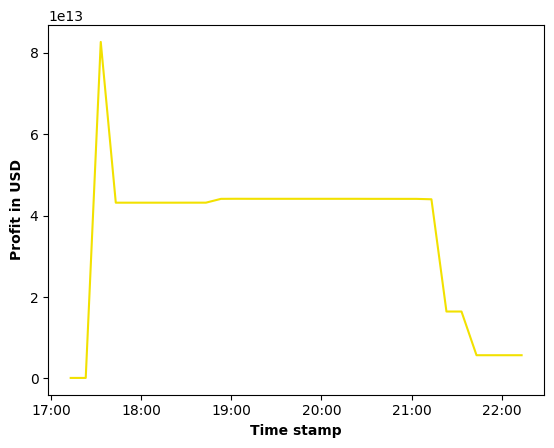

In [64]:
import matplotlib.pyplot as plt
import datetime
fig = plt.figure()
ax = fig.add_subplot(111)
x = [datetime.datetime.now() + datetime.timedelta(minutes=i*10) - datetime.timedelta(hours=5) for i in range(31)]
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.plot(x, stats.Overall_arbitrage_USD_profit, '#F2E100')

plt.xlabel('Time stamp', fontweight='bold')
plt.ylabel('Profit in USD', fontweight='bold')

Text(0, 0.5, 'Number of arbitrage positions')

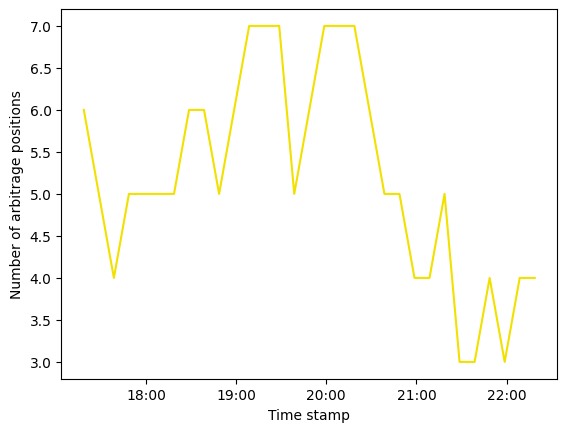

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = [datetime.datetime.now() + datetime.timedelta(minutes=i*10) - datetime.timedelta(hours=5) for i in range(31)]
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.plot(x, stats.Number_of_arbitrage_poistions, '#F2E100')
plt.xlabel('Time stamp')
plt.ylabel('Number of arbitrage positions')

Text(0, 0.5, 'ROE in %')

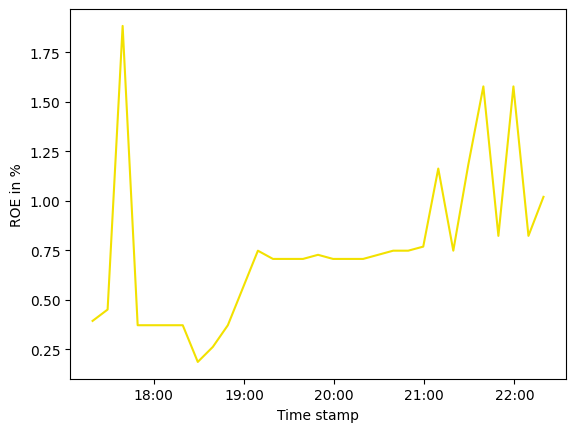

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = [datetime.datetime.now() + datetime.timedelta(minutes=i*10) - datetime.timedelta(hours=5) for i in range(31)]
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.plot(x , stats['ROE_in_%'], '#F2E100')
plt.xlabel('Time stamp')
plt.ylabel('ROE in %')